In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from scipy.io import loadmat
from tqdm import tqdm_notebook as tqdm
%matplotlib inline
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

In [2]:
# Add new methods here.
cbcolors={'cgreen':(26, 110, 53),
          'cgrass':(123, 252, 3),
          'cbrown':(161, 100, 56),
          'cyellow':(237, 187, 36),
          'cpurple':(177, 87, 250),
          'cpurblue' : (194, 207, 242),          
          'cgrey':(157, 163, 163),        
          'cblue':(66, 120, 245),
          'csky': (148, 250, 255),
          'corange':(245, 130, 69),
          'ccyan': (8, 189, 171),
          'crose' : (235, 101, 157),
          'cpink' : (255, 212, 212),
          'cred': (219, 15, 15),          
          'cdark': (0, 0, 0),
         }
cbcolors={k:(v[0]/255,v[1]/255,v[2]/255) for k,v in cbcolors.items()}

methods = ['SPADesc','AWDesc','SIFT1024','r2d2_WAF_N16.size-256-1024','delf-new','d2-net',
           'superpoint','hesaff', 'hesaffnet','aslfeat','lf-net','disk-2000','disk-8000']
names = ['Ours','AWDesc-CA(2K)','SIFT','R2D2','DELF','D2-Net','Superpoint','Hes. Aff. + Root-SIFT', 
         'HAN + HN++','ASLFeat','LF-Net','DISK(2K)','DISK(8K)']

colors = [cbcolors['cpurple'], 
          cbcolors['cdark'], 
          cbcolors['cpurblue'], cbcolors['cpurblue'], 
          cbcolors['cgrey'],  
          cbcolors['cgrass'], cbcolors['ccyan'], cbcolors['cbrown'],  
          cbcolors['cyellow'], cbcolors['corange'],  
          cbcolors['cblue'],  cbcolors['cgreen'], cbcolors['csky'],  
          cbcolors['crose'],  
          cbcolors['cpink'],  
          cbcolors['cred'],  ]


linestyles = ['-', 
              '--', '-.', 
              '--', 
              '--', '-.', '--', 
              '-', '--', 
              '-', '-.', '-', 
              '--', 
              '--',               
              '--', '--',
             ]

In [3]:
# Change here if you want to use top K or all features.
# top_k = 2000
top_k = 2000 
n_i = 52
n_v = 56
dataset_path = ' 'lim = [1, 15]
rng = np.arange(lim[0], lim[1] + 1)
def mnn_matcher(descriptors_a, descriptors_b):
    device = descriptors_a.device
    sim = descriptors_a @ descriptors_b.t()
    nn12 = torch.max(sim, dim=1)[1]
    nn21 = torch.max(sim, dim=0)[1]
    ids1 = torch.arange(0, sim.shape[0], device=device)
    mask = (ids1 == nn21[nn12])
    matches = torch.stack([ids1[mask], nn12[mask]])
    return matches.t().data.cpu().numpy()
def benchmark_features(read_feats):
    seq_names = sorted(os.listdir(dataset_path))

    n_feats = []
    n_matches = []
    seq_type = []
    i_err = {thr: 0 for thr in rng}
    v_err = {thr: 0 for thr in rng}

    for seq_idx, seq_name in tqdm(enumerate(seq_names), total=len(seq_names)):
        keypoints_a, descriptors_a = read_feats(seq_name, 1)
        n_feats.append(keypoints_a.shape[0])

        for im_idx in range(2, 7):
            keypoints_b, descriptors_b = read_feats(seq_name, im_idx)
            n_feats.append(keypoints_b.shape[0])

            matches = mnn_matcher(
                torch.from_numpy(descriptors_a).to(device=device), 
                torch.from_numpy(descriptors_b).to(device=device)
            )
            
            homography = np.loadtxt(os.path.join(dataset_path, seq_name, "H_1_" + str(im_idx)))
            
            pos_a = keypoints_a[matches[:, 0], : 2] 
            pos_a_h = np.concatenate([pos_a, np.ones([matches.shape[0], 1])], axis=1)
            pos_b_proj_h = np.transpose(np.dot(homography, np.transpose(pos_a_h)))
            pos_b_proj = pos_b_proj_h[:, : 2] / pos_b_proj_h[:, 2 :]

            pos_b = keypoints_b[matches[:, 1], : 2]

            dist = np.sqrt(np.sum((pos_b - pos_b_proj) ** 2, axis=1))

            n_matches.append(matches.shape[0])
            seq_type.append(seq_name[0])
            
            if dist.shape[0] == 0:
                dist = np.array([float("inf")])
            
            for thr in rng:
                if seq_name[0] == 'i':
                    i_err[thr] += np.mean(dist <= thr)
                else:
                    v_err[thr] += np.mean(dist <= thr)
    
    seq_type = np.array(seq_type)
    n_feats = np.array(n_feats)
    n_matches = np.array(n_matches)
    
    return i_err, v_err, [seq_type, n_feats, n_matches]
def summary(stats):
    seq_type, n_feats, n_matches = stats
    print('# Features: {:f} - [{:d}, {:d}]'.format(np.mean(n_feats), np.min(n_feats), np.max(n_feats)))
    print('# Matches: Overall {:f}, Illumination {:f}, Viewpoint {:f}'.format(
        np.sum(n_matches) / ((n_i + n_v) * 5), 
        np.sum(n_matches[seq_type == 'i']) / (n_i * 5), 
        np.sum(n_matches[seq_type == 'v']) / (n_v * 5))
    )
    

def eval_summary_matching(results, thres=[1, 3, 5, 10], save_npy=None):
    np.set_printoptions(precision=2)
    summary = ""
    n_i = 52
    n_v = 56
    i_err, v_err, stats = results
    seq_type, n_feats, n_matches = stats

    if save_npy:
        print(f"Save results to {save_npy}")
        np.save(save_npy, np.array(results, dtype=object))

    summary += "#Features: mean={:f} min={:d} max={:d}\n".format(
        np.mean(n_feats), np.min(n_feats), np.max(n_feats)
    )
    summary += "#(Old)Matches: a={:f}, i={:f}, v={:f}\n".format(
        np.sum(n_matches) / ((n_i + n_v) * 5),
        np.sum(n_matches[seq_type == "i"]) / (n_i * 5),
        np.sum(n_matches[seq_type == "v"]) / (n_v * 5),
    )
    summary += "#Matches: a={:f}, i={:f}, v={:f}\n".format(
        np.mean(n_matches),
        np.mean(n_matches[seq_type == "i"]),
        np.mean(n_matches[seq_type == "v"]),
    )

    thres = np.array(thres)
    ierr = np.array([i_err[th] / (n_i * 5) for th in thres])
    verr = np.array([v_err[th] / (n_v * 5) for th in thres])
    aerr = np.array([(i_err[th] + v_err[th]) / ((n_i + n_v) * 5) for th in thres])
    summary += "MMA@{} px:\na={}\ni={}\nv={}\n".format(
        thres, 
        ", ".join(["{:f}".format(a) for a in aerr]), 
        ", ".join(["{:f}".format(i) for i in ierr]), 
        ", ".join(["{:f}".format(v) for v in verr])
    )
    return summary

def generate_read_function(method, extension='ppm'):
    def read_function(seq_name, im_idx):
        aux = np.load(os.path.join(dataset_path, seq_name, '%d.%s.%s' % (im_idx, extension, method)))
        if top_k is None:
            return aux['keypoints'], aux['descriptors']
        else:
            assert('scores' in aux)
            ids = np.argsort(aux['scores'])[-top_k :]
            return aux['keypoints'][ids, :], aux['descriptors'][ids, :]
    return read_function
def sift_to_rootsift(descriptors):
    return np.sqrt(descriptors / np.expand_dims(np.sum(np.abs(descriptors), axis=1), axis=1) + 1e-16)
def parse_mat(mat):
    keypoints = mat['keypoints'][:, : 2]
    raw_descriptors = mat['descriptors']
    l2_norm_descriptors = raw_descriptors / np.expand_dims(np.sum(raw_descriptors ** 2, axis=1), axis=1)
    descriptors = sift_to_rootsift(l2_norm_descriptors)
    if top_k is None:
        return keypoints, descriptors
    else:
        assert('scores' in mat)
        ids = np.argsort(mat['scores'][0])[-top_k :]
        return keypoints[ids, :], descriptors[ids, :]
if top_k is None:
    cache_dir = 'cache'
else:
    cache_dir = 'cache-top'
if not os.path.isdir(cache_dir):
    os.mkdir(cache_dir)
errors = {}
i=0
for method in methods:
    output_file = os.path.join(cache_dir, method + '.npy')
    print(names[i])
    i+=1
    if method == 'hesaff':
        read_function = lambda seq_name, im_idx: parse_mat(loadmat(os.path.join(dataset_path, seq_name, '%d.ppm.hesaff' % im_idx), appendmat=False))
    else:
        if method == 'delf' or method == 'delf-new':
            read_function = generate_read_function(method, extension='png')
        else:
            read_function = generate_read_function(method)
    if os.path.exists(output_file):
        print('Loading precomputed errors...')
        errors[method] = np.load(output_file, allow_pickle=True)
    else:
        errors[method] = benchmark_features(read_function)
        np.save(output_file, errors[method])
    summary(errors[method][-1])
    print(eval_summary_matching(errors[method]))

Ours
Loading precomputed errors...
# Features: 1229.084877 - [78, 2000]
# Matches: Overall 546.077778, Illumination 500.138462, Viewpoint 588.735714
#Features: mean=1229.084877 min=78 max=2000
#(Old)Matches: a=546.077778, i=500.138462, v=588.735714
#Matches: a=546.077778, i=500.138462, v=588.735714
MMA@[ 1  3  5 10] px:
a=0.432990, 0.807452, 0.884943, 0.926862
i=0.498767, 0.820904, 0.906249, 0.955842
v=0.371911, 0.794962, 0.865158, 0.899951

AWDesc-CA(2K)
Loading precomputed errors...
# Features: 818.376543 - [82, 1000]
# Matches: Overall 407.479630, Illumination 431.257692, Viewpoint 385.400000
#Features: mean=818.376543 min=82 max=1000
#(Old)Matches: a=407.479630, i=431.257692, v=385.400000
#Matches: a=407.479630, i=431.257692, v=385.400000
MMA@[ 1  3  5 10] px:
a=0.417906, 0.769516, 0.850071, 0.900506
i=0.482810, 0.788976, 0.883737, 0.941807
v=0.357639, 0.751447, 0.818810, 0.862156

SIFT
Loading precomputed errors...
# Features: 977.340517 - [183, 1026]
# Matches: Overall 426.500000

# Plotting

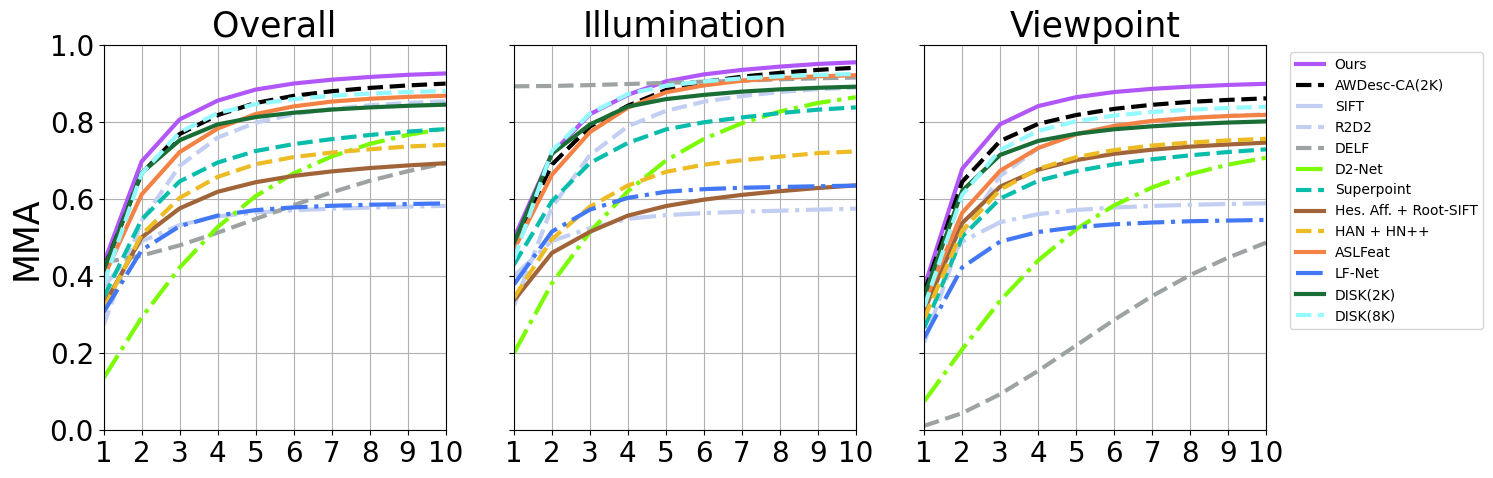

In [7]:
plt_lim = [1, 10]
plt_rng = np.arange(plt_lim[0], plt_lim[1] + 1)
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=25)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
for method, name, color, ls in zip(methods, names, colors, linestyles):
    i_err, v_err, _ = errors[method]
    plt.plot(plt_rng, [(i_err[thr] + v_err[thr]) / ((n_i + n_v) * 5) for thr in plt_rng], color=color, ls=ls, linewidth=3, label=name)
plt.title('Overall')
plt.xlim(plt_lim)
plt.xticks(plt_rng)
plt.ylabel('MMA')
plt.ylim([0, 1])
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)

plt.subplot(1, 3, 2)
for method, name, color, ls in zip(methods, names, colors, linestyles):
    i_err, v_err, _ = errors[method]
    plt.plot(plt_rng, [i_err[thr] / (n_i * 5) for thr in plt_rng], color=color, ls=ls, linewidth=3, label=name)
plt.title('Illumination')
plt.xlim(plt_lim)
plt.xticks(plt_rng)
plt.ylim([0, 1])
plt.gca().axes.set_yticklabels([])
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)

plt.subplot(1, 3, 3)
for method, name, color, ls in zip(methods, names, colors, linestyles):
    i_err, v_err, _ = errors[method]
    plt.plot(plt_rng, [v_err[thr] / (n_v * 5) for thr in plt_rng], color=color, ls=ls, linewidth=3, label=name)
plt.title('Viewpoint')
plt.xlim(plt_lim)
plt.xticks(plt_rng)
plt.ylim([0, 1])
plt.gca().axes.set_yticklabels([])
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

if top_k is None:
    plt.savefig('hseq.pdf', bbox_inches='tight', dpi=300)
else:
    plt.savefig('hseq-top.pdf', bbox_inches='tight', dpi=300)